# Astropy introduction for Gammapy users


## Introduction

To become efficient at using Gammapy, you have to learn to use some parts of Astropy, especially FITS I/O and how to work with Table, Quantity, SkyCoord, Angle and Time objects.

Gammapy is built on Astropy, meaning that data in Gammapy is often stored in Astropy objects, and the methods on those objects are part of the public Gammapy API.

This tutorial is a quick introduction to the parts of Astropy you should know become familiar with to use Gammapy (or also when not using Gammapy, just doing astronomy from Python scripts). The largest part is devoted to tables, which are a the most important building block for Gammapy (event lists, flux points, light curves, ... many other thing are store in Table objects).

We will:
- open and write fits files with [io.fits](http://docs.astropy.org/en/stable/io/fits/index.html)
- manipulate [coordinates](http://docs.astropy.org/en/stable/coordinates/): [SkyCoord](http://docs.astropy.org/en/stable/api/astropy.coordinates.SkyCoord.html)  and [Angle](http://docs.astropy.org/en/stable/coordinates/angles.html) classes
- use [units](http://docs.astropy.org/en/stable/units/index.html) and [Quantities](http://docs.astropy.org/en/stable/api/astropy.units.Quantity.html). See also this [tutorial](http://www.astropy.org/astropy-tutorials/Quantities.html)
- manipulate [Times and Dates](http://docs.astropy.org/en/stable/time/index.html)
- use [tables](http://docs.astropy.org/en/stable/table/index.html) with the [Table](http://docs.astropy.org/en/stable/api/astropy.table.Table.html) class with the Fermi catalog
- define regions in the sky with the [region](http://astropy-regions.readthedocs.io/en/latest/getting_started.html) package

## Setup

In [1]:
# to make plots appear in the notebook
%matplotlib inline  
import matplotlib.pyplot as plt

In [2]:
# If something below doesn't work, here's how you
# can check what version of Numpy and Astropy you have
# All examples should work with Astropy 1.3,
# most even with Astropy 1.0
import numpy as np
import astropy
print('numpy:', np.__version__)
print('astropy:', astropy.__version__)

('numpy:', '1.11.2')
('astropy:', u'1.3.3')


In [3]:
# Units, Quantities and constants
import astropy.units as u
from astropy.units import Quantity
import astropy.constants as cst

from astropy.io import fits
from astropy.table import Table
from astropy.coordinates import SkyCoord, Angle
from astropy.time import Time

## Units and constants

### Basic usage

In [4]:
# One can create a Quantity like this
L = Quantity(1e35, unit='erg/s')
# or like this
d = 8 * u.kpc

# then one can produce new Quantities
flux = L / (4 * np.pi * d ** 2)

# And convert its value to any (homogeneous) unit
print(flux.to('erg cm-2 s-1'))
print(flux.to('W/m2'))
# print(flux.to('Ci')) would raise a UnitConversionError


1.30589744313e-11 erg / (cm2 s)
1.30589744313e-14 W / m2


More generally a Quantity is a numpy array with a unit.

In [5]:
E = np.logspace(1, 4, 10) * u.GeV
print(E.to('TeV'))

[  0.01         0.02154435   0.04641589   0.1          0.21544347
   0.46415888   1.           2.15443469   4.64158883  10.        ] TeV


Here we compute the interaction time of protons.

In [6]:
x_eff = 30 * u.mbarn
density = 1 * u.cm ** -3 

interaction_time = (density * x_eff * cst.c) ** -1

interaction_time.to('Myr')

<Quantity 35.23336113415385 Myr>

### Use Quantities in functions. 

We compute here the energy loss rate of an electron of kinetic energy E in magnetic field B. See formula (5B10) in this [lecture](http://www.cv.nrao.edu/course/astr534/SynchrotronPower.html)


4.05193281315e-13 erg / s


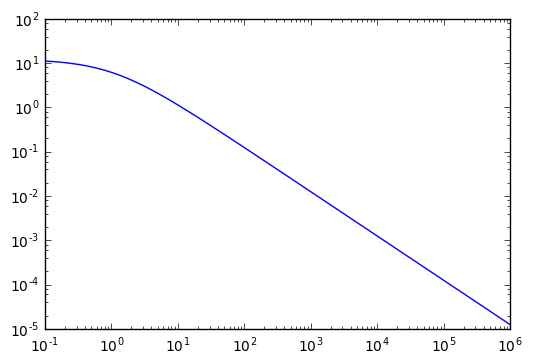

In [7]:
def electron_energy_loss_rate(B, E):
    """ energy loss rate of an electron of kinetic energy E in magnetic field B
    """
    U_B = B ** 2 / (2 * cst.mu0)
    gamma = E / (cst.m_e * cst.c ** 2) + 1   # note that this works only because E/(cst.m_e*cst.c**2) is dimensionless
    beta = np.sqrt(1 - 1 / gamma ** 2)
    return 4. / 3. * cst.sigma_T * cst.c * gamma ** 2 * beta ** 2 * U_B

print(electron_energy_loss_rate(1e-5 * u.G, 1 * u.TeV).to('erg/s'))

# Now plot it
E_elec = np.logspace(-1., 6, 100) * u.MeV
B = 1 * u.G
plt.loglog(E_elec,(E_elec / electron_energy_loss_rate(B, E_elec)).to('yr'))

A frequent issue is homogeneity. One can use decorators to ensure it.

In [8]:
# This ensures that B and E are homogeneous to magnetic field strength and energy
# If not will raise a UnitError exception
@u.quantity_input(B=u.T,E=u.J)     
def electron_energy_loss_rate(B, E):
    """ energy loss rate of an electron of kinetic energy E in magnetic field B
    """
    U_B = B ** 2 / (2 * cst.mu0)
    gamma = E / (cst.m_e * cst.c ** 2) + 1   # note that this works only because E/(cst.m_e*cst.c**2) is dimensionless
    beta = np.sqrt(1 - 1 / gamma ** 2)
    return 4. / 3. * cst.sigma_T * cst.c * gamma ** 2 * beta ** 2 * U_B

# Now try it
try:
    print(electron_energy_loss_rate(1e-5 * u.G, 1 * u.Hz).to('erg/s'))
except u.UnitsError as message:
    print('Incorrect unit: '+ str(message))


Incorrect unit: Argument 'E' to function 'electron_energy_loss_rate' must be in units convertible to 'J'.


## Coordinates

Note that SkyCoord are arrays of coordinates. We will see that in more detail in the next section.

In [9]:
# Different ways to create a SkyCoord
c1 = SkyCoord(10.625, 41.2, frame='icrs', unit='deg')
c1 = SkyCoord('00h42m30s', '+41d12m00s', frame='icrs')

c2 = SkyCoord(83.633083, 22.0145, unit='deg')
# If you have internet access, you could also use this to define the `source_pos`:
# c2 = SkyCoord.from_name("Crab")     # Get the name from CDS

print(c1.ra,c2.dec)

print('Distance to Crab: ', c1.separation(c2))    # separation returns an Angle object
print('Distance to Crab: ', c1.separation(c2).degree)

(<Longitude 10.624999999999998 deg>, <Latitude 22.0145 deg>)
('Distance to Crab: ', <Angle 63.2078415848386 deg>)
('Distance to Crab: ', 63.2078415848386)


### Coordinate transformations

How to change between coordinate frames. The Crab in Galactic coordinates.

In [10]:
c2b = c2.galactic
print(c2b)
print(c2b.l, c2b.b)

<SkyCoord (Galactic): (l, b) in deg
    ( 184.55745771, -5.78435696)>
(<Longitude 184.5574577123824 deg>, <Latitude -5.784356964188559 deg>)


## Time 

Is the Crab visible now?

In [11]:
now = Time.now()
print(now)
print(now.mjd)

2017-10-02 17:40:57.531458
58028.736777


In [12]:
# define the location for the AltAz system
from astropy.coordinates import EarthLocation, AltAz
paris = EarthLocation(lat=48.8567 * u.deg, lon=2.3508 * u.deg )
 
# calculate the horizontal coordinates 
crab_altaz = c2.transform_to(AltAz(obstime=now, location=paris))

print(crab_altaz)

<SkyCoord (AltAz: obstime=2017-10-02 17:40:57.531458, location=(4200910.643257838, 172456.78503911156, 4780088.658775934) m, pressure=0.0 hPa, temperature=0.0 deg_C, relative_humidity=0, obswl=1.0 micron): (az, alt) in deg
    ( 14.90928038, -17.81022343)>


## Table: Manipulating the 3FGL catalog

Here we are going to do some selections with the 3FGL catalog. To do so we use the Table class from astropy.

### Accessing the table
First, we need to open the catalog in a Table. 

In [13]:
# Open Fermi 3FGL from the repo
table = Table.read("../datasets/catalogs/fermi/gll_psc_v16.fit.gz")
# Alternatively, one can grab it from the server.
#table = Table.read("http://fermi.gsfc.nasa.gov/ssc/data/access/lat/4yr_catalog/gll_psc_v16.fit")

IOError: [Errno 2] No such file or directory: '../datasets/catalogs/fermi/gll_psc_v16.fit.gz'

In [ ]:
# Note that a single FITS file might contain different tables in different HDUs
filename = "../datasets/catalogs/fermi/gll_psc_v16.fit.gz" 
# You can load a `fits.HDUList` and check the extension names
print([_.name for _ in fits.open(filename)])
# Then you can load by name or integer index via the `hdu` option
extended_source_table = Table.read(filename, hdu='ExtendedSources')

### General informations on the Table


In [ ]:
table.info()

In [ ]:
# Statistics on each column
table.info('stats')

In [ ]:
### list of column names
table.colnames

In [ ]:
# HTML display
# table.show_in_browser(jsviewer=True)
# table.show_in_notebook(jsviewer=True)

### Accessing the table

In [ ]:
# The header keywords are stored as a dict
# table.meta
table.meta['TSMIN']

In [ ]:
# First row
table[0]

In [ ]:
# Spectral index of the 5 first entries
table[:5]['Spectral_Index']

In [ ]:
# Which source has the lowest spectral index?
min_index_row = table[np.argmin(table['Spectral_Index'])]
print('Hardest source: ',min_index_row['Source_Name'], 
                         min_index_row['CLASS1'],min_index_row['Spectral_Index'])

# Which source has the largest spectral index?
max_index_row = table[np.argmax(table['Spectral_Index'])]
print('Softest source: ',max_index_row['Source_Name'], 
                         max_index_row['CLASS1'],max_index_row['Spectral_Index'])



### Quantities and SkyCoords from a Table

In [ ]:
fluxes = table['nuFnu1000_3000'].quantity
print(fluxes)
coord = SkyCoord(table['GLON'],table['GLAT'],frame='galactic')
print(coord.fk5)

### Selections in a Table

Here we select Sources according to their class and do some whole sky chart

In [ ]:
# Get coordinates of FSRQs
fsrq = np.where( np.logical_or(table['CLASS1']=='fsrq ',table['CLASS1']=='FSQR '))

In [ ]:
# This is here for plotting purpose...
#glon = glon.wrap_at(180*u.degree)

# Open figure
fig = plt.figure(figsize=(14,8))
ax = fig.add_subplot(111, projection="aitoff")
ax.scatter(coord[fsrq].l.wrap_at(180*u.degree).radian, 
           coord[fsrq].b.radian, 
           color = 'k', label='FSRQ')
ax.grid(True)
ax.legend()
# ax.invert_xaxis()  -> This does not work for projections...  

In [ ]:
# Now do it for a series of classes
fig = plt.figure(figsize=(14,10))
ax = fig.add_subplot(111, projection="aitoff")

source_classes = ['','psr','spp', 'fsrq', 'bll', 'bin']

for source_class in source_classes:
    # We select elements with correct class in upper or lower characters
    index = np.array([_.strip().lower() == source_class for _ in table['CLASS1']])
    
    label = source_class if source_class else 'unid'
    
    ax.scatter(
        coord[index].l.wrap_at(180*u.degree).radian, 
        coord[index].b.radian,
        label=label,
    )

ax.grid(True)
ax.legend()

### Creating tables

A `Table` is basically a dict mapping column names to column values, where a column value is a Numpy array (or Quantity object, which is a Numpy array sub-class). This implies that adding columns to a table after creation is nice and easy, but adding a row is hard and slow, basically all data has to be copied and all objects that make up a Table have to be re-created.

Here's one way to create a `Table` from scratch: put the data into a list of dicts, and then call the `Table` constructor with the `rows` option.

In [ ]:
rows = [
    dict(a=42, b='spam'),
    dict(a=43, b='ham'),
]
my_table = Table(rows=rows)
my_table

### Writing tables

Writing tables to files is easy, you can just give the filename and format you want.
If you run a script repeatedly you might want to add `overwrite=True`.

In [ ]:
# Examples how to write a table in different formats
# Uncomment if you really want to do it

# my_table.write('/tmp/table.fits', format='fits')
# my_table.write('/tmp/table.fits.gz', format='fits')
# my_table.write('/tmp/table.ecsv', format='ascii.ecsv')

FITS (and some other formats, e.g. HDF5) support writing multiple tables to a single file.
The `table.write` API doesn't support that directly yet.
Here's how you can currently write multiple tables to a FITS file: you have to convert the `astropy.table.Table` objects to `astropy.io.fits.BinTable` objects, and then store them in a `astropy.io.fits.HDUList` objects and call `HDUList.writeto`.

In [ ]:
my_table2 = Table(data=dict(a=[1, 2, 3]))
hdu_list = fits.HDUList([
    fits.PrimaryHDU(), # need an empty primary HDU
    fits.table_to_hdu(my_table),
    fits.table_to_hdu(my_table2),
])
# hdu_list.writeto('tables.fits')

## Using regions

Let's try to find sources inside a circular region in the sky.

For this we will rely on the [region package](http://astropy-regions.readthedocs.io/en/latest/index.html)

We first create a circular region centered on a given SkyCoord with a given radius.

In [ ]:
from regions import CircleSkyRegion

#center = SkyCoord.from_name("M31")
center = SkyCoord(ra='0h42m44.31s', dec='41d16m09.4s')

circle_region = CircleSkyRegion(
    center=center,
    radius=Angle(50, 'deg')
)

We now use the contains method to search objects in this circular region in the sky.

In [ ]:
in_region = circle_region.contains(coord)

In [ ]:
fig = plt.figure(figsize=(14,10))
ax = fig.add_subplot(111, projection="aitoff")
ax.scatter(coord[in_region].l.radian, coord[in_region].b.radian)

### Tables and pandas

[pandas](http://pandas.pydata.org/) is one of the most-used packages in the scientific Python stack. Numpy provides the `ndarray` object and functions that operate on `ndarray` objects. Pandas provides the `Dataframe` and `Series` objects, which roughly correspond to the Astropy `Table` and `Column` objects. While both `pandas.Dataframe` and `astropy.table.Table` can often be used to work with tabular data, each has features that the other doesn't. When Astropy was started, it was decided to not base it on `pandas.Dataframe`, but to introduce `Table`, mainly because `pandas.Dataframe` doesn't support multi-dimensional columns, but FITS does and astronomers use sometimes.

But `pandas.Dataframe` has a ton of features that `Table` doesn't, and is highly optimised, so if you find something to be hard with `Table`, you can convert it to a `Dataframe` and do your work there. As explained in the [interfacing with the pandas package](http://docs.astropy.org/en/stable/table/pandas.html) page in the Astropy docs, it is easy to go back and forth between Table and Dataframe:

    table = Table.from_pandas(dataframe)
    dataframe = table.to_pandas()

Let's try it out with the Fermi-LAT catalog.

One little trick is needed when converting to a dataframe: we need to drop the multi-dimensional columns that the 3FGL catalog uses for a few columns (flux up/down errors, and lightcurves):

In [ ]:
scalar_colnames = tuple(name for name in table.colnames if len(table[name].shape) <= 1)
data_frame = table[scalar_colnames].to_pandas()

In [ ]:
# If you want to have a quick-look at the dataframe:
# data_frame
# data_frame.info()
# data_frame.describe()

In [ ]:
# Just do demonstrate one of the useful DataFrame methods,
# this is how you can count the number of sources in each class:
data_frame['CLASS1'].value_counts()

If you'd like to learn more about pandas, have a look [here](http://pandas.pydata.org/pandas-docs/stable/10min.html) or [here](http://nbviewer.jupyter.org/github/jakevdp/PythonDataScienceHandbook/blob/master/notebooks/03.00-Introduction-to-Pandas.ipynb).

## Exercices

- When searched for the hardest and softest sources in 3FGL we did not look at the type of spectrum (PL, ECPL etc), find the hardest and softest PL sources instead. 
- Replot the full sky chart of sources in ra-dec instead of galactic coordinates
- Find the 3FGL sources visible from Paris now